# Lesson 4
### 1. Using the camera !

First some imports :

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


import RPi.GPIO as GPIO  # GPIO library for controlling Raspberry Pi's pins
import time
import os

import pytesseract
from PIL import Image
from picamera import PiCamera

ModuleNotFoundError: No module named 'RPi'

### 2. Taking a simple image

In [2]:
# Start the Pi camera to capture an image 
print("[INFO] Taking picture...")
vs = cv2.VideoCapture(0)  # Initialize the camera
time.sleep(2.0)  # Let the camera warm up

# Capture a single frame (image)
ret, frame = vs.read()  # Read a single frame from the camera
vs.release()  # Release the camera after capturing the image
 

# Save the captured image 
output_filename = "./captured_images/captured_image.jpg"
cv2.imwrite(output_filename, frame)  # Save the image to disk
print(f"[INFO] Image saved as {output_filename}")

# Show the image  
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert the image from BGR to RGB
plt.imshow(frame_rgb)  # Display the image
plt.axis("off")  # Turn off axis labels
plt.show()  # Show the image in the notebook


[INFO] Taking picture...


NameError: name 'cv2' is not defined

## Detection model ! 

We're going to use a small deep learning network named YOLO (You Only Look Once). It has become very popular these last years. They provide a 'tiny' model which already performs extremely well on small hardware infrastructures like our rasberry pi. 

Here a short visual description of how it works:

![YOLO](./images/yolo_design.jpg "YOLO Explained")


### 3. Use a pretrained detection network

[INFO] Loading YOLO model...


[INFO] Taking picture...


[ WARN:0] global ../modules/videoio/src/cap_gstreamer.cpp (961) open OpenCV | GStreamer warning: Cannot query video position: status=0, value=-1, duration=-1


[INFO] Image saved as ./captured_images/detected_image_with_YOLO.jpg


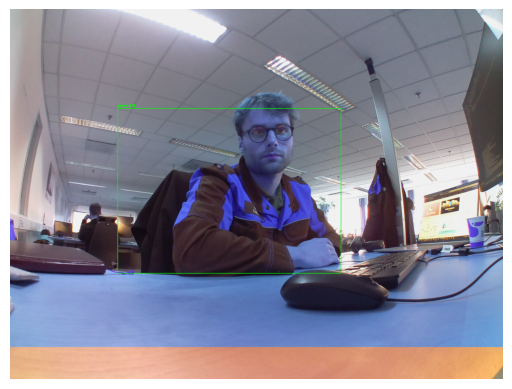

In [6]:

# Load YOLO model 
print("[INFO] Loading YOLO model...")
net = cv2.dnn.readNet("/home/pi/Labo_Computer_Vision/deep_learning_tools/yolov3-tiny.weights",  # Load YOLO weights
                      "/home/pi/Labo_Computer_Vision/deep_learning_tools/yolov3-tiny.cfg")  # Load YOLO configuration

layer_names = net.getLayerNames()  # Get the names of all the layers in the model
output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]  # Get the output layers (detection layers)

# Load the COCO class names (80 object classes YOLO is trained on)
with open("/home/pi/Labo_Computer_Vision/deep_learning_tools/coco.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]  # Read class names into a list

# Start the Pi camera to capture an image 
print("[INFO] Taking picture...")
vs = cv2.VideoCapture(0)  # Initialize the camera
time.sleep(2.0)  # Let the camera warm up

# Capture a single frame (image)
ret, frame = vs.read()  # Read a single frame from the camera
vs.release()  # Release the camera after capturing the image

# Convert the captured image to a blob format for YOLO (resizing it to 416x416 as expected by YOLO)
blob = cv2.dnn.blobFromImage(frame, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
net.setInput(blob)  # Feed the blob into the YOLO model for processing

outs = net.forward(output_layers)  # Perform forward pass (inference) to get detections => running it through the YOLO model

# Image dimensions
height, width, channels = frame.shape  # Get the dimensions of the captured image

# Lists to store information about detected objects
class_ids = []  # List to store the class IDs of the detected objects
confidences = []  # List to store confidence scores
boxes = []  # List to store the bounding boxes

# Process each output from the YOLO model
for out in outs:
    for detection in out:
        scores = detection[5:]  # Extract class probabilities
        class_id = np.argmax(scores)  # Get the ID of the class with the highest score
        confidence = scores[class_id]  # Get the confidence level for that class

        # Filter out weak detections based on a confidence threshold
        if confidence > 0.5:  # Only consider detections with confidence > 50%
            # Object detected
            center_x = int(detection[0] * width)  # X coordinate of the object's center
            center_y = int(detection[1] * height)  # Y coordinate of the object's center
            w = int(detection[2] * width)  # Width of the bounding box
            h = int(detection[3] * height)  # Height of the bounding box

            # Coordinates for the bounding box
            x = int(center_x - w / 2)  # X coordinate of the top-left corner
            y = int(center_y - h / 2)  # Y coordinate of the top-left corner

            boxes.append([x, y, w, h])  # Add the box to the list
            confidences.append(float(confidence))  # Add the confidence score
            class_ids.append(class_id)  # Add the class ID

# Apply non-max suppression to avoid multiple boxes for the same object
indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

# Draw the bounding boxes on the image and label the detected objects
for i in indexes.flatten():
    x, y, w, h = boxes[i]  # Get the coordinates and dimensions of the bounding box
    label = str(classes[class_ids[i]])  # Get the class name of the detected object
    confidence = confidences[i]  # Get the confidence score

    # Draw the bounding box
    cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Green box

    # Put the label and confidence score above the box
    cv2.putText(frame, f"{label} {int(confidence * 100)}%", (x, y - 10), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Save the processed image with bounding boxes
output_filename = "./captured_images/detected_image_with_YOLO.jpg"
cv2.imwrite(output_filename, frame)  # Save the image to disk
print(f"[INFO] Image saved as {output_filename}")

# Show the image in the Jupyter Notebook using Matplotlib
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert the image from BGR to RGB
plt.imshow(frame_rgb)  # Display the image
plt.axis("off")  # Turn off axis labels
plt.show()  # Show the image in the notebook


## Character recognition !

### 4. Some OCR model !

In [1]:
import cv2
import pytesseract
import os
import time
import matplotlib.pyplot as plt

# Zorg ervoor dat de directory voor de opgeslagen beelden bestaat
output_dir = './captured_images'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Start de Pi camera om een afbeelding vast te leggen
print("[INFO] Neem een foto...")
vs = cv2.VideoCapture(0)  # Initialiseer de camera
time.sleep(2.0)  # Laat de camera opwarmen

# Capture a single frame (image)
ret, frame = vs.read()  # Lees een enkel beeld van de camera
vs.release()  # Sluit de camera na het vastleggen van het beeld

# Controleer of het frame succesvol is vastgelegd
if not ret:
    print("[ERROR] Kan geen beeld vastleggen.")
else:
    # Bewaar de vastgelegde afbeelding
    output_filename = os.path.join(output_dir, 'ocr_image.jpg')
    cv2.imwrite(output_filename, frame)
    print(f"[INFO] Afbeelding opgeslagen als {output_filename}")

    # Converteer het beeld naar grijswaarden voor betere OCR-resultaten
    gray_image = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Sla de grijswaardenafbeelding op (optioneel)
    gray_image_path = os.path.join(output_dir, 'ocr_image_gray.jpg')
    cv2.imwrite(gray_image_path, gray_image)

    # Voer OCR uit met Tesseract op de grijswaardenafbeelding
    print("[INFO] OCR uitvoeren...")
    text = pytesseract.image_to_string(gray_image)

    # Toon de herkende tekst
    print("[INFO] Herkende tekst:")
    print(text)

    # Sla de herkende tekst op in een bestand
    output_text_path = os.path.join(output_dir, 'recognized_text.txt')
    with open(output_text_path, 'w') as text_file:
        text_file.write(text)
    print(f"[INFO] Tekst opgeslagen in {output_text_path}")

    # Toon het beeld in de Jupyter-notebook of via matplotlib
    frame_rgb = cv2.cvtColor(gray_image, cv2.COLOR_BGR2RGB)  # Converteer naar RGB voor matplotlib
    plt.imshow(frame_rgb, cmap='gray')  # Toon de afbeelding
    plt.axis("off")  # Zet de


[INFO] Neem een foto...
[INFO] Afbeelding opgeslagen als ./captured_images\ocr_image.jpg
[INFO] OCR uitvoeren...


TesseractNotFoundError: tesseract is not installed or it's not in your PATH. See README file for more information.